# Pop and Country Songs Audio Features Analysis:

### Background:

The songs that we hear around these days, it is hard to distinguish a country song from a pop song, but is there really a difference between the two?  Are there song features which will be able to classify these two genres?



<br>For this project, we will be extracting Spotify Features via the Spotify API, where the following data will be used:

[Spotify Audio Features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)
- __acousticness__: describes how many acoustic sounds the track has vs. how many electric sounds [0.0 to 1.0] 
- __danceability__: describes how suitable a track is for dancing based on a combination of musical elements.
  [0.0 least danceable to 1.0 most danceable)
- duration_ms
- __energy__: represents perceptual measure of intensity and activity.  typically energetic feels fast, loud and noisy.
  [0.0 to 1.0]
- instrumentalness
- key
- liveness
- loudness
- mode
- speechiness
- tempo
- time signature
- __valence__: measure from [0.0 to 1.0] describes the musical positiveness conveyed by a track.  Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)

[Spotify Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/)
- bar length: a bar or measure is a segment of time as a given number of beats
- beats length: The time interval of beats throughout the track.  A beat is the basic time unit of a piece of music.
- sections length: defined by large ariation in rhythm or timbre e.g. chorus, verse, bridge, guitar solo etc.
- segment length:  each segment contains a roughly consistent sound throughout its duration
  * average & __median pitch__ - values from 0 to 1 that describe the relative dominance of every pitch in the scale.
  * average & __median timbre__ - timbre is the quality of musical note or sound that distinguishes different types of 
    musical instruments or voices.


We will be analyzing songs which have been tagged with the word 'pop' or 'country' from the Million Songs Database https://labrosa.ee.columbia.edu/millionsong/.

and in the end specifically explore if there are differences between Taylor Swift's pre-pop - country songs and her pop songs.


### Problem Definition:

- How does country and pop music differ?  
- Are there differences between the two music genres? -- Can we find some patterns that would differentiate these two music genres? 
- What patterns do we find with the song features?


[additional reference](http://theconversation.com/musical-genres-are-out-of-date-but-this-new-system-explains-why-you-might-like-both-jazz-and-hip-hop-63539)



### Limitations

- since we are relying on the tags from the Million Songs Database to filter out pop and country songs, we can potentially have a 'noisy' data, since we could have jazz, rock songs, or songs with other genres which were added with incorrect tags.  But we should be able to see all these when we try to create clusters for our songs.  

- Because of the limited time, Analysis was done only on the Audio Features from Spotify.



 



### Acquiring Data Set:

Data sets were acquired from the different Sources:

(1) To get the list of Artists, Songs, and genre tags records were extracted from the Million Song Database

https://labrosa.ee.columbia.edu/millionsong/ 

(2) To get audio features of the songs, Spotify API was used, given
the artist name, and song title, the spotify Track ID can be retrieved, which can then be used to query the audio features for the song.


(3) To get the lyrics of the songs, the Genius API will be used, to search the song based on a given Artist Name, and song title.


the following notebooks will show the processing for each of these data acquisition steps:
getArtistSong.ipynb:  get Artist/Songs from Million Song Database
getAudioFeatures.ipynb:    get Audio features via Spotify API
getLyrics.ipynb:      get Song Lyrics via Genius API

and were based on the following Open Source codes:


### Cleaning The Data:

1) Combine the song data collected from Spotify with the Spotify Features, and the Lyrics collected from Genius.
   Only keep records which both Spotify Features, and Lyrics Text from Genius.
   
   
2) The Spotify Features extracted were in JSON format.  Reformatted records to create a column for every Spotify Feature attribute.

3) Added a column 'genre' which was derived based on the tags found from the Song record.  A song was classified as 'pop' if 'pop' occurred in the tag the most, 'country' if 'country' occurred in the tag the most, otherwise, it will be tagged as 'other'.  This column will only be used for verifying output, but cannot provide a good score of accuracy since songs can be mis-tagged.  i.e. Beyonce's song records are tagged with 'country' instead of 'pop'.

4) Lyrics Text were initially cleaned to remove tags, i.e. [Verses], [Chorus]. And used to filter out to only work with songs where Language == English.





In [1]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 2000

## Visualizing and Exploring Features



In [3]:
songsDF = pd.read_pickle('../data/Songs_input.p')

In [4]:
songsDF.columns

Index(['level_0', 'index', 'artist_id', 'tags', 'track_id', 'title', 'song_id',
       'release', 'artist_mbid', 'artist_name', 'duration',
       'artist_familiarity', 'artist_hotttnesss', 'year', 'track_7digitalid',
       'shs_perf', 'shs_work', 'lyrics_text', 'spotifyURI', 'songFeatures',
       'language', 'lyrics_clean', 'FKRG1', 'fkrg_sent1', 'FKRG2',
       'fkrg_sent2', 'bar_len', 'beat_len', 'seg_len', 'pitch_mean',
       'pitch_med', 'timbre_mean', 'timbre_med', 'drop_row', 'genre',
       'country_cnt', 'pop_cnt', 'other_cnt', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

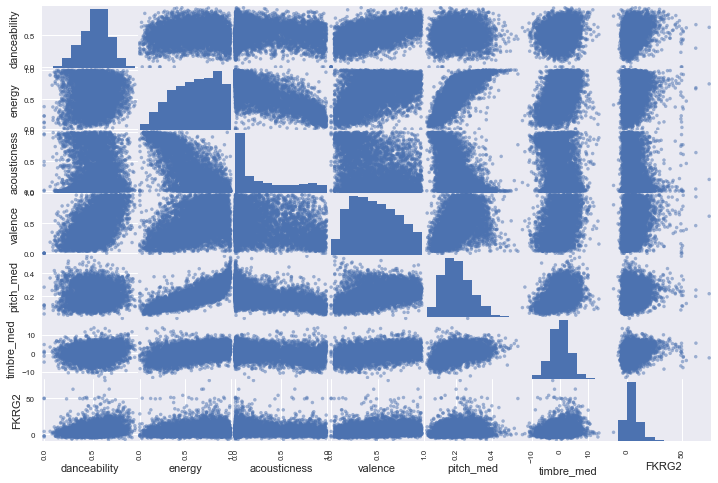

In [67]:
from pandas.plotting import scatter_matrix


features = ['danceability', 'energy', 'acousticness', 'valence', 'pitch_med',  'timbre_med',
            'FKRG2']

scatter_matrix(songsDF[features], figsize=(12, 8))

plt.savefig('../images/features2_scatter_matrix.png')

#### Some of the relationships between features we will find from this plot are:
- pitch+timbre - positive correlation
- valence+danceability - positive correlation
- energy+acousticness - negative correlation (high energy - low acoustic)
- energy+pitch - positive correlation

In [68]:
corr_matrix = songsDF[features].corr()

In [69]:
corr_matrix

danceability    energy  acousticness   valence  pitch_med  \
danceability      1.000000  0.056624     -0.058779  0.495712   0.051807   
energy            0.056624  1.000000     -0.750568  0.452442   0.790793   
acousticness     -0.058779 -0.750568      1.000000 -0.316676  -0.549708   
valence           0.495712  0.452442     -0.316676  1.000000   0.429611   
pitch_med         0.051807  0.790793     -0.549708  0.429611   1.000000   
timbre_med        0.149024  0.386414     -0.267652  0.334961   0.375089   
FKRG2             0.209703  0.155210     -0.121677  0.201699   0.176555   

              timbre_med     FKRG2  
danceability    0.149024  0.209703  
energy          0.386414  0.155210  
acousticness   -0.267652 -0.121677  
valence         0.334961  0.201699  
pitch_med       0.375089  0.176555  
timbre_med      1.000000  0.202781  
FKRG2           0.202781  1.000000

In [70]:
country = songsDF[songsDF.genre == 'country']
pop     = songsDF[songsDF.genre == 'pop']

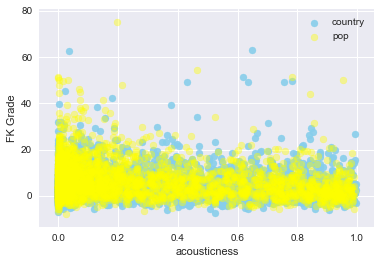

In [71]:
plt.scatter(country['acousticness'],country['FKRG2'],marker='o',color='skyblue',label='country',alpha=0.9)
plt.scatter(pop['acousticness'],pop['FKRG2'],marker='o',color='yellow', label='pop',alpha=0.4)
plt.xlabel('acousticness')
plt.ylabel('FK Grade')
plt.legend()
plt.show()

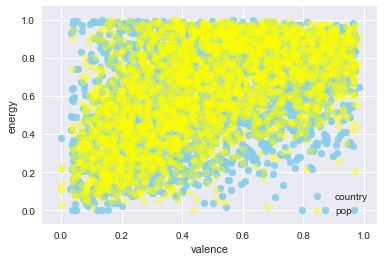

In [72]:
plt.scatter(country['valence'],country['energy'],marker='o',color='skyblue',label='country',alpha=0.9)
plt.scatter(pop['valence'],pop['energy'],marker='o',color='yellow', label='pop',alpha=0.4)
plt.xlabel('valence')
plt.ylabel('energy')
plt.legend()
plt.show()

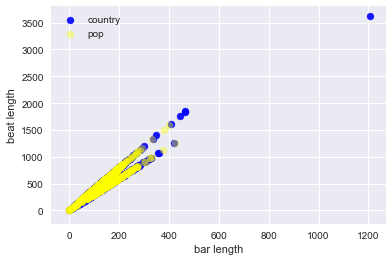

In [73]:
plt.scatter(country['bar_len'],country['beat_len'],marker='o',color='blue',label='country',alpha=0.9)
plt.scatter(pop['bar_len'],pop['beat_len'],marker='o',color='yellow', label='pop',alpha=0.4)
plt.xlabel('bar length')
plt.ylabel('beat length')
plt.legend()
plt.show()

#### The bar length and beat length are similar for the songs tagged as country and pop, and will therefore not be used for the analysis.

## Scale the values of the features, and apply PCA for dimensionality reduction.

The features where we found high correlation were selected to be used for further analysis:
- pitch+timbre - positive correlation
- valence+danceability - positive correlation
- energy+acousticness - negative correlation (high energy - low acoustic)
- energy+pitch - positive correlation

In [74]:
## Scale features before applying PCA.  Features in our dataframe our not standardized, we have some features which 
## are normalized, and some which are not.

from sklearn.preprocessing import StandardScaler



In [75]:
x = songsDF.loc[:, features].values
y = songsDF.loc[:, 'genre'].values

In [76]:
x = StandardScaler().fit_transform(x)

In [77]:
Xtr = x.copy()   #Xtr will be scaled values

In [78]:
from sklearn.decomposition import PCA

#### Determine number of components for PCA

In [79]:
pca = PCA(n_components=None).fit(x)
components = pca.components_
ex_var = pca.explained_variance_ratio_

In [80]:
sums = ex_var.cumsum()
n_comps = 0
for i, s in enumerate(sums):
    if s > 0.9:
        n_comps = i
        break

In [81]:
n_comps

4

In [82]:
comp_range = range(pca.n_components_)

In [83]:
import numpy as np

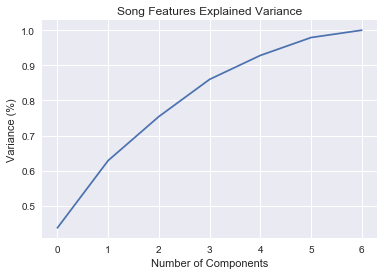

In [84]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Song Features Explained Variance')
plt.show()

In [85]:
data_scaled = pd.DataFrame(Xtr, columns = features)

In [86]:
# transform dataset using n_comps = 2
pca = PCA(n_components=3).fit(Xtr)
x = pca.transform(Xtr)

In [87]:
pca3 = pd.DataFrame(pca.components_, columns=data_scaled.columns, index=['PC-1','PC-2','PC-3']).T
pca3

PC-1      PC-2      PC-3
danceability -0.176329  0.697713 -0.340150
energy       -0.506982 -0.279035 -0.053104
acousticness  0.431182  0.296903  0.078659
valence      -0.392017  0.388740 -0.332534
pitch_med    -0.473280 -0.231325  0.006619
timbre_med   -0.332980  0.099383  0.259921
FKRG2        -0.193423  0.364250  0.834931

### Perform clustering on scaled features Xtr

determine the optimum value of K for clustering

In [88]:
from sklearn.cluster import KMeans

In [89]:
#x4: corresponds to transformed features to PCA for components = 4 

def test(data, nClusterRange):
    inertias = np.zeros(len(nClusterRange))
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++').fit(data)
        inertias[i] = model.inertia_
    return inertias

In [90]:
import numpy as np
kRange = range(1,12)
KmeanTopics = test(Xtr, kRange)

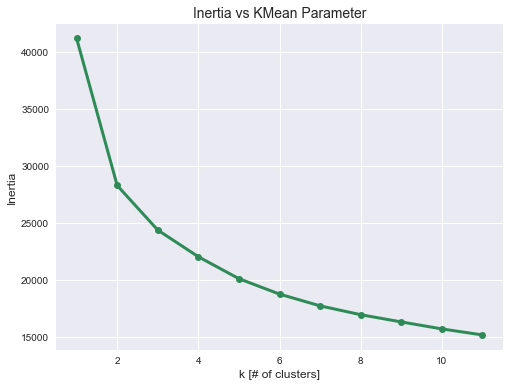

In [91]:
figInertiaWithK = plt.figure(figsize=(8,6))

plt.plot(kRange, KmeanTopics, 'o-', color='seagreen', linewidth=3)
plt.xlabel('k [# of clusters]', size=12)
plt.ylabel('Inertia', size=12)
plt.title('Inertia vs KMean Parameter', size=14)



Let us apply KMeans clustering algorithms using the transformed features and see what patterns/clusters this gives us. 

## KMeans clustering (K = 3) using Scaled features Xtr

In [92]:
km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(Xtr)
cluster_labels = km.labels_
songsDF['K_cluster_n3'] = cluster_labels

In [93]:
songsDF['pca1'] = x[:,0]
songsDF['pca2'] = x[:,1]
songsDF['pca3'] = x[:,2]


In [94]:
c1 = songsDF[songsDF.K_cluster_n3 == 0]
c2 = songsDF[songsDF.K_cluster_n3 == 1]
c3 = songsDF[songsDF.K_cluster_n3 == 2]


### Plotting first 3 components from transformed dataset to visualize the resulting clusters

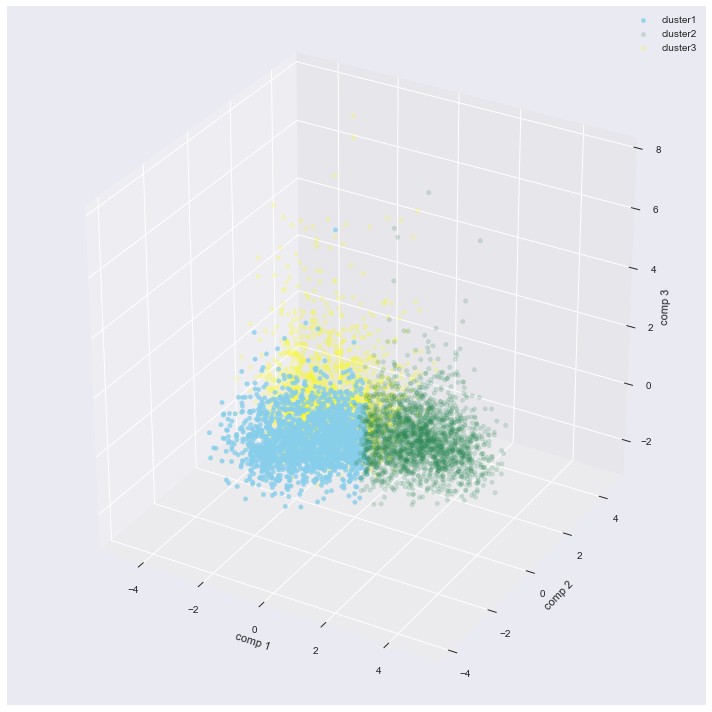

In [95]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig3d = plt.figure(figsize=(10, 10))
ax = fig3d.add_subplot(111, projection='3d')

p = ax.scatter(c1['pca1'], c1['pca2'], c1['pca3'], color='skyblue', alpha=0.8, label='cluster1')
p = ax.scatter(c2['pca1'], c2['pca2'], c2['pca3'], color='seagreen', alpha=0.2, label='cluster2')
p = ax.scatter(c3['pca1'], c3['pca2'], c3['pca3'], color='yellow', alpha=0.2, label='cluster3')
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')

ax.legend()
fig3d.tight_layout()
plt.savefig('../images/KMeans3D_PCA1_3_N6.png')
#cb = fig3d.colorbar(p)
#cb.set_label('Similarity with (5,5,5)', size=14)

In [96]:
country = songsDF[songsDF.genre == 'country']
pop     = songsDF[songsDF.genre == 'pop']

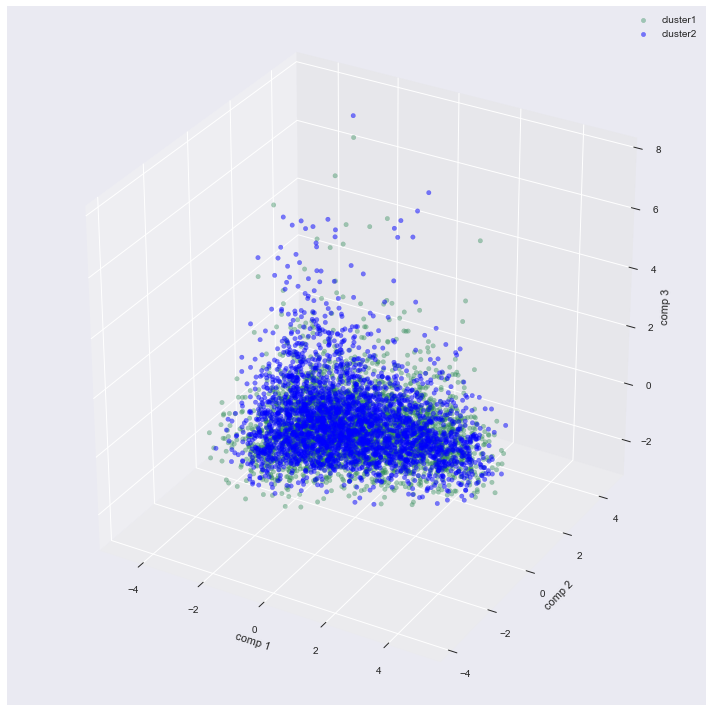

In [97]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig3d = plt.figure(figsize=(10, 10))
ax = fig3d.add_subplot(111, projection='3d')

p = ax.scatter(country['pca1'], country['pca2'], country['pca3'], color='seagreen', alpha=0.4, label='cluster1')
p = ax.scatter(pop['pca1'], pop['pca2'], pop['pca3'], color='blue', alpha=0.5, label='cluster2')
#p = ax.scatter(c3['pca1'], c3['pca2'], c3['pca3'], color='yellow', alpha=0.2, label='cluster3')
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')

ax.legend()
fig3d.tight_layout()
plt.savefig('../images/KMeans3D_PCA1_3_CountryPop.png')
#cb = fig3d.colorbar(p)
#cb.set_label('Similarity with (5,5,5)', size=14)

## Looking deeper into the resulting cluster features:

### Cluster 0 - high energy, low valence, high pitch, low acoustic

In [98]:
songsDF[songsDF.K_cluster_n3 == 0][features ].describe()  

danceability       energy  acousticness      valence    pitch_med  \
count   1870.000000  1870.000000   1870.000000  1870.000000  1870.000000   
mean       0.446135     0.777715      0.076960     0.424618     0.249865   
std        0.114893     0.142406      0.123700     0.173266     0.073825   
min        0.000000     0.000063      0.000002     0.000000     0.095250   
25%        0.370250     0.667000      0.001158     0.295000     0.193500   
50%        0.460500     0.795500      0.017850     0.416500     0.235125   
75%        0.531000     0.901000      0.104000     0.548750     0.300875   
max        0.717000     0.999000      0.989000     0.965000     0.537500   

        timbre_med        FKRG2  
count  1870.000000  1870.000000  
mean      0.299067     4.068433  
std       2.573247     4.955931  
min      -8.877000    -7.840000  
25%      -1.359563     0.560000  
50%       0.277500     3.365000  
75%       1.914937     6.820000  
max       9.700500    49.620000

### Cluster 1 - High energy, high danceability, high valence, high timbre

In [99]:
songsDF[songsDF.K_cluster_n3 == 1][features ].describe() 

danceability       energy  acousticness      valence    pitch_med  \
count   2098.000000  2098.000000   2098.000000  2098.000000  2098.000000   
mean       0.497610     0.346221      0.610748     0.290911     0.134844   
std        0.137439     0.141215      0.274499     0.162875     0.039788   
min        0.000000     0.000020      0.000002     0.000000     0.036250   
25%        0.408000     0.246000      0.415000     0.168250     0.107000   
50%        0.514500     0.351500      0.668500     0.262000     0.131750   
75%        0.596000     0.450000      0.842750     0.388000     0.159250   
max        0.883000     0.789000      0.996000     0.966000     0.311750   

        timbre_med        FKRG2  
count  2098.000000  2098.000000  
mean     -1.987182     3.827655  
std       3.304226     5.426307  
min     -13.276000    -6.410000  
25%      -4.148125     0.330000  
50%      -1.997750     2.845000  
75%       0.065313     6.347500  
max      13.745000    50.800000

### Cluster 2 - lower energy, high acoustic, lowest valence, low timbre, low pitch

In [100]:
songsDF[songsDF.K_cluster_n3 == 2][features ].describe()  

danceability       energy  acousticness      valence    pitch_med  \
count   1913.000000  1913.000000   1913.000000  1913.000000  1913.000000   
mean       0.651331     0.709438      0.195843     0.711976     0.239141   
std        0.096913     0.158956      0.211459     0.162049     0.059705   
min        0.231000     0.071100      0.000009     0.032800     0.076500   
25%        0.587000     0.595000      0.030000     0.605000     0.196000   
50%        0.646000     0.725000      0.116000     0.727000     0.235000   
75%        0.713000     0.839000      0.302000     0.841000     0.276000   
max        0.938000     0.998000      0.992000     0.982000     0.547000   

        timbre_med        FKRG2  
count  1913.000000  1913.000000  
mean      1.890002     9.422687  
std       2.899437     8.601763  
min      -9.486500    -7.470000  
25%      -0.073000     3.630000  
50%       1.841500     7.650000  
75%       3.808500    13.240000  
max      18.913250    75.020000

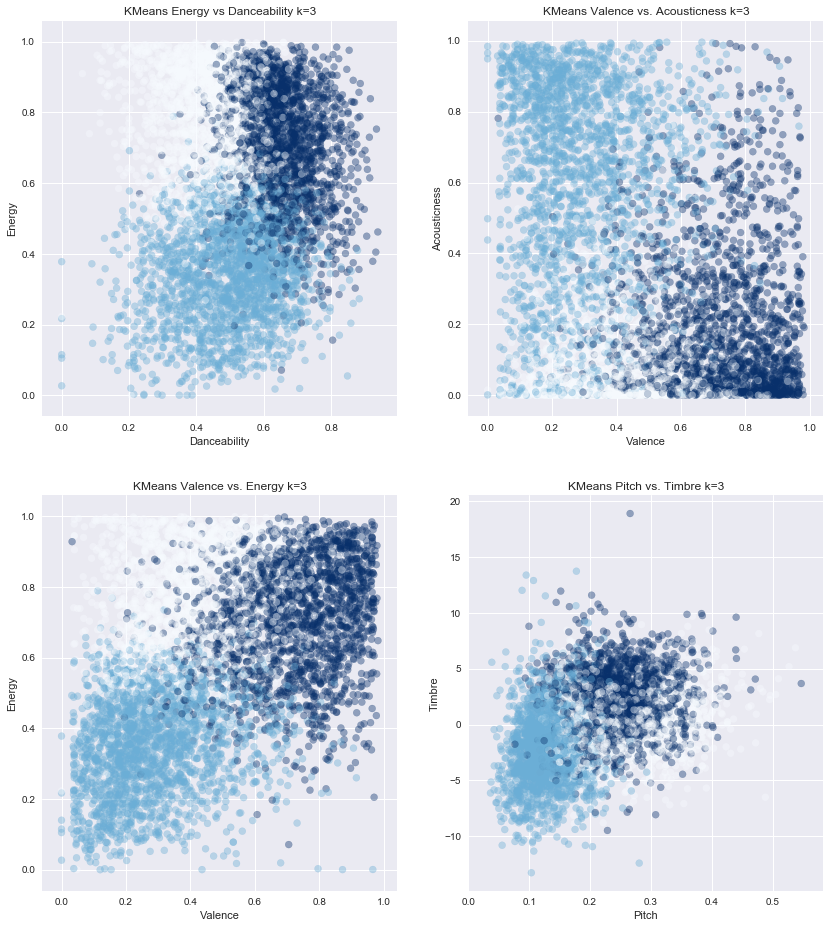

In [101]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('KMeans Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('KMeans Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('KMeans Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('KMeans Pitch vs. Timbre k=3')

plt.savefig('../images/KMeans_FeaturesClusters_K3.png')

In [102]:
km = KMeans(n_clusters=2, random_state=0)
km.fit_transform(Xtr)
cluster_labels = km.labels_
songsDF['K_cluster_n2'] = cluster_labels

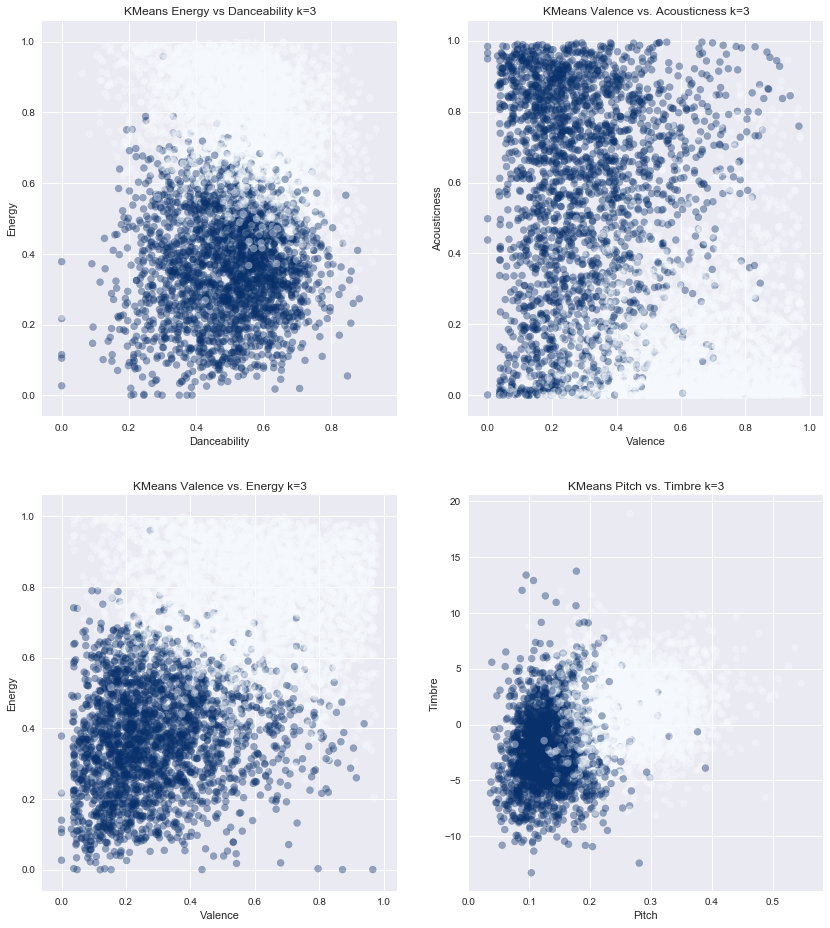

In [103]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('KMeans Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('KMeans Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('KMeans Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('KMeans Pitch vs. Timbre k=3')

plt.savefig('../images/KMeans_FeaturesClusters_K2.png')

In [104]:
songsDF[songsDF.K_cluster_n2 == 0][features ].describe()  

danceability       energy  acousticness      valence    pitch_med  \
count   3512.000000  3512.000000   3512.000000  3512.000000  3512.000000   
mean       0.556175     0.757932      0.128238     0.587383     0.249717   
std        0.145232     0.147025      0.173495     0.211491     0.066137   
min        0.000000     0.156000      0.000002     0.000000     0.076500   
25%        0.467000     0.657750      0.005275     0.425000     0.200438   
50%        0.567000     0.775500      0.051650     0.591000     0.241000   
75%        0.653000     0.878000      0.187000     0.755000     0.291500   
max        0.938000     0.999000      0.992000     0.982000     0.547000   

        timbre_med        FKRG2  
count  3512.000000  3512.000000  
mean      1.225681     7.000071  
std       2.810848     7.647557  
min      -8.076000    -7.840000  
25%      -0.663938     1.907500  
50%       1.089500     5.485000  
75%       3.044250    10.330000  
max      18.913250    75.020000

In [105]:
songsDF[songsDF.K_cluster_n2 == 1][features ].describe() 

danceability       energy  acousticness      valence    pitch_med  \
count   2369.000000  2369.000000   2369.000000  2369.000000  2369.000000   
mean       0.494287     0.369775      0.569666     0.296955     0.139560   
std        0.139788     0.153867      0.295595     0.170363     0.041697   
min        0.000000     0.000020      0.000002     0.000000     0.036250   
25%        0.400000     0.260000      0.335000     0.172000     0.110750   
50%        0.508000     0.372000      0.628000     0.264000     0.137000   
75%        0.594000     0.480000      0.829000     0.392000     0.165000   
max        0.883000     0.959000      0.996000     0.966000     0.389500   

        timbre_med        FKRG2  
count  2369.000000  2369.000000  
mean     -1.814634     3.832731  
std       3.301624     5.375550  
min     -13.276000    -7.470000  
25%      -3.954000     0.340000  
50%      -1.774500     2.890000  
75%       0.229500     6.340000  
max      13.745000    50.800000

In [148]:
num_songs = 300

In [149]:
country = songsDF[songsDF.genre == 'country']
pop = songsDF[songsDF.genre == 'pop']

In [153]:
Top_songs = songsDF[songsDF.artist_hotttnesss > 0.5].sort_values('song_id', ascending=False).head(num_songs)

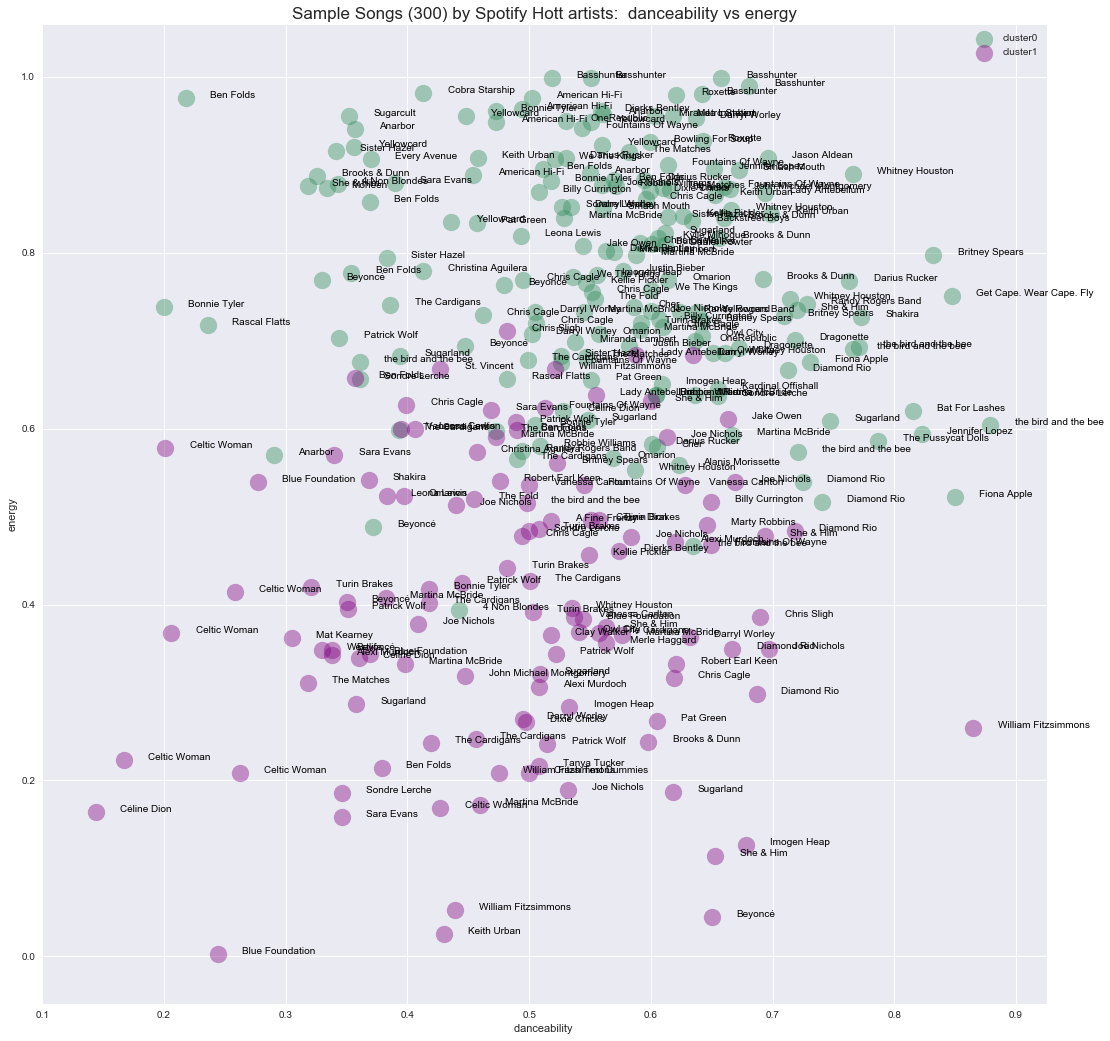

In [156]:
fig = plt.figure(figsize=(18,18))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='danceability', y='energy', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='danceability', y='energy', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')
#p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n3 == 2] ,x='danceability', y='energy', fit_reg=False, marker="o", color='red',
#                           scatter_kws={'s':300, 'alpha':0.4},label='cluster2')
for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.danceability.iloc[line] + 0.02, Top_songs.energy.iloc[line], Top_songs.artist_name.iloc[line],
            horizontalalignment='left', size='medium',color='black')
p1.set_xlabel('danceability ')
p1.set_ylabel('energy')
plt.legend()
p1.set_title('Sample Songs ({}) by Spotify Hott artists:  danceability vs energy'.format(num_songs), fontsize=17)
plt.savefig('../images/Songs_dance_energy_Kmeans.png')

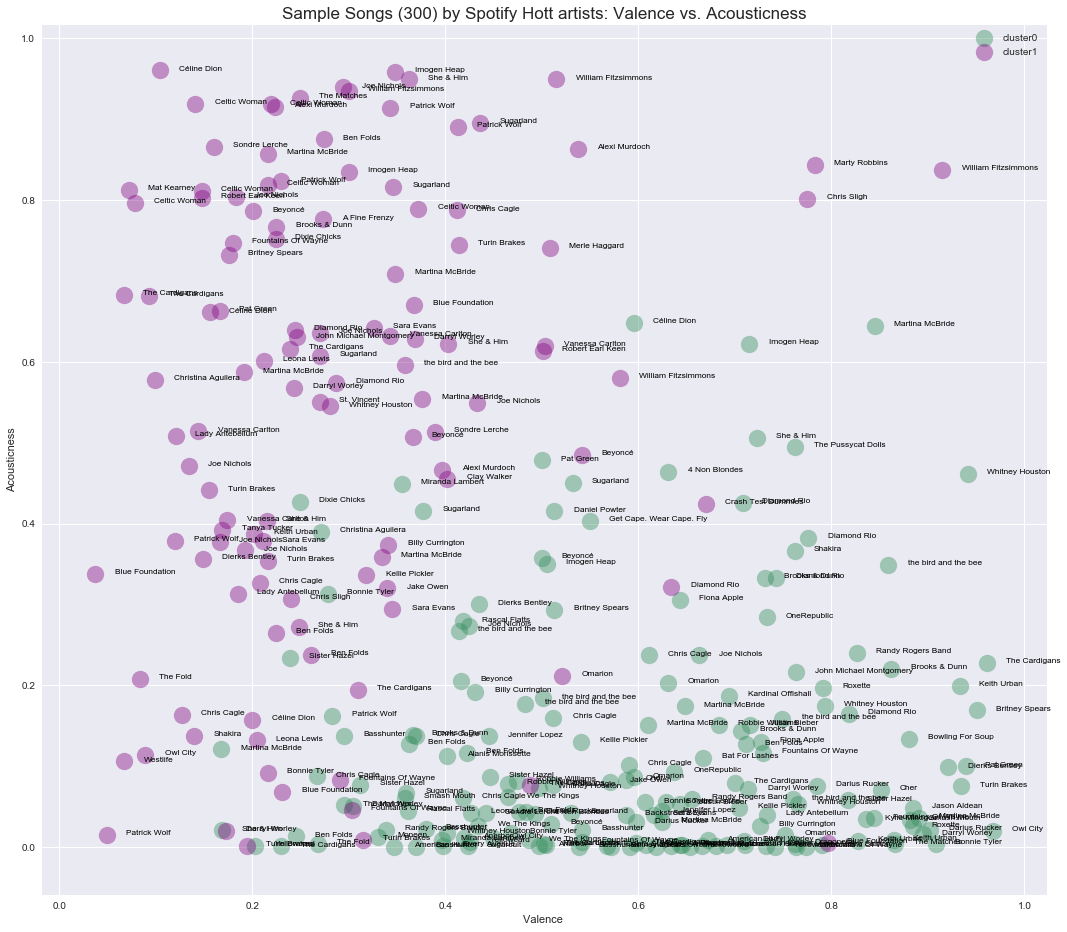

In [157]:
fig = plt.figure(figsize=(18,16))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='valence', y='acousticness', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='valence', y='acousticness', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')

for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.valence.iloc[line] + 0.02, Top_songs.acousticness.iloc[line], Top_songs.artist_name.iloc[line],
            horizontalalignment='left', size='small',color='black')
p1.set_xlabel('Valence ')
p1.set_ylabel('Acousticness')
plt.legend()
p1.set_title('Sample Songs ({}) by Spotify Hott artists: Valence vs. Acousticness'.format(num_songs), fontsize=17)
plt.savefig('../images/Songs_Valence_Acousticness_Kmeans.png')

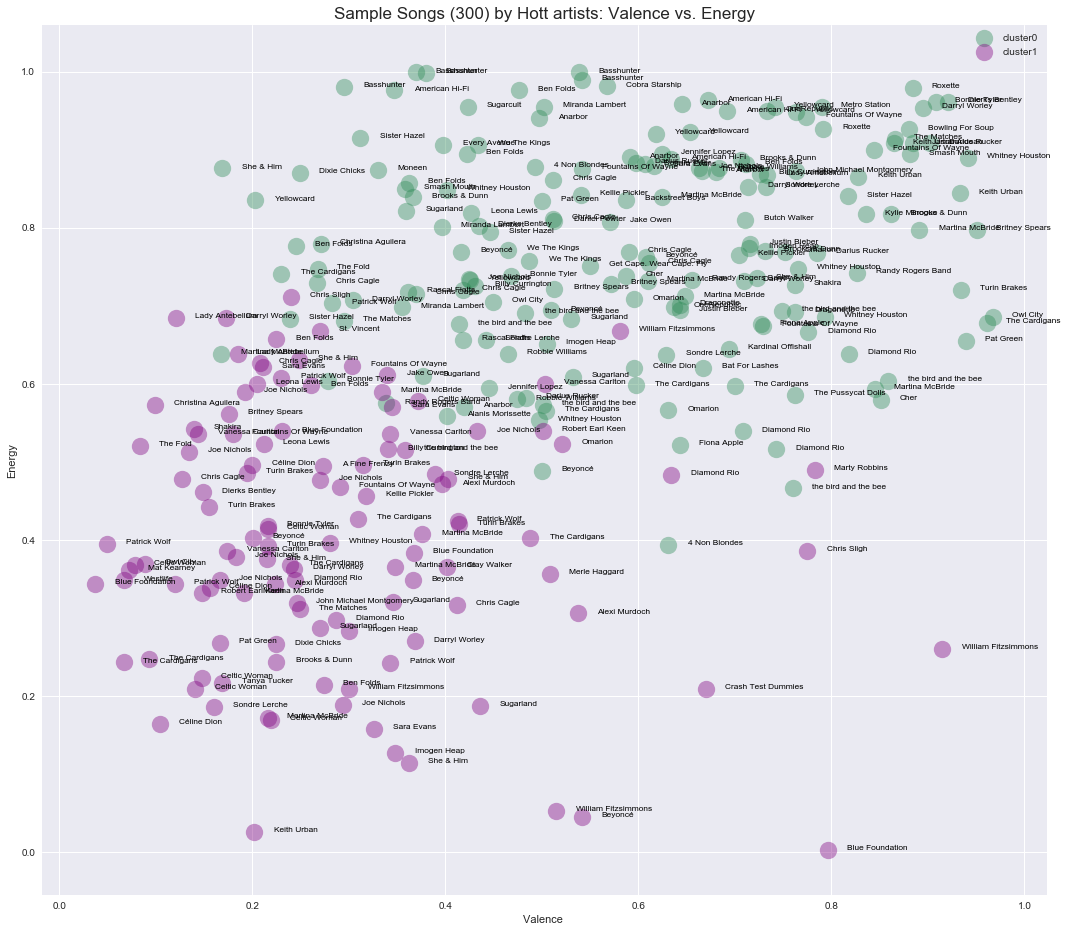

In [158]:
fig = plt.figure(figsize=(18,16))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='valence', y='energy', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='valence', y='energy', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')
#p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n3_9 == 2] ,x='valence', y='energy', fit_reg=False, marker="o", color='red',
#                           scatter_kws={'s':300, 'alpha':0.4},label='cluster2')
for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.valence.iloc[line] + 0.02, Top_songs.energy.iloc[line], Top_songs.artist_name.iloc[line],
            horizontalalignment='left', size='small',color='black')
p1.set_xlabel('Valence ')
p1.set_ylabel('Energy')
p1.set_title('Sample Songs ({}) by Hott artists: Valence vs. Energy'.format(num_songs), fontsize=17)
plt.legend()
plt.savefig('../images/Songs_Valence_Energy_Kmeans.png')

In [183]:
songsDF[(songsDF.artist_hotttnesss > 0.5) & (songsDF.K_cluster_n2 == 0)][['artist_name', 'title', 'genre']].sort_values('artist_name')

artist_name  \
424              4 Non Blondes   
425              4 Non Blondes   
426              4 Non Blondes   
427              4 Non Blondes   
428              4 Non Blondes   
429              4 Non Blondes   
430              4 Non Blondes   
431              4 Non Blondes   
423              4 Non Blondes   
1024             A Fine Frenzy   
1027             A Fine Frenzy   
1029             A Fine Frenzy   
1022             A Fine Frenzy   
1021             A Fine Frenzy   
1015             A Fine Frenzy   
1017             A Fine Frenzy   
613                Ace of Base   
612                Ace of Base   
611                Ace of Base   
610                Ace of Base   
609                Ace of Base   
608                Ace of Base   
614                Ace of Base   
607                Ace of Base   
3325                Afterhours   
5866         Alanis Morissette   
2310             Alexi Murdoch   
3150            American Hi-Fi   
3151            American Hi-Fi   
3155            American Hi-Fi   
3153            American Hi-Fi   
3154            American Hi-Fi   
3149            American Hi-Fi   
3152            American Hi-Fi   
3148            American Hi-Fi   
3141            American Hi-Fi   
3146            American Hi-Fi   
3147            American Hi-Fi   
3135            American Hi-Fi   
3136            American Hi-Fi   
3137            American Hi-Fi   
3138            American Hi-Fi   
3134            American Hi-Fi   
3140            American Hi-Fi   
3142            American Hi-Fi   
3143            American Hi-Fi   
3144            American Hi-Fi   
3139            American Hi-Fi   
1228                   Anarbor   
1229                   Anarbor   
1230                   Anarbor   
1231                   Anarbor   
1232                   Anarbor   
1233                   Anarbor   
1234                   Anarbor   
1235                   Anarbor   
1236                   Anarbor   
1238                   Anarbor   
1237                   Anarbor   
1240                   Anarbor   
1241                   Anarbor   
1242                   Anarbor   
1243                   Anarbor   
1239                   Anarbor   
2756           Backstreet Boys   
2753           Backstreet Boys   
2752           Backstreet Boys   
2750           Backstreet Boys   
2748           Backstreet Boys   
2746           Backstreet Boys   
2745           Backstreet Boys   
2744           Backstreet Boys   
2742           Backstreet Boys   
2757           Backstreet Boys   
2739           Backstreet Boys   
2738           Backstreet Boys   
2737           Backstreet Boys   
2736           Backstreet Boys   
2735           Backstreet Boys   
2731           Backstreet Boys   
2732           Backstreet Boys   
2743           Backstreet Boys   
2758           Backstreet Boys   
2734           Backstreet Boys   
2733           Backstreet Boys   
3971                Basshunter   
3973                Basshunter   
3972                Basshunter   
3970                Basshunter   
3969                Basshunter   
3968                Basshunter   
3967                Basshunter   
3966                Basshunter   
3965                Basshunter   
3964                Basshunter   
3959                Basshunter   
3962                Basshunter   
3961                Basshunter   
3960                Basshunter   
3963                Basshunter   
3958                Basshunter   
3957                Basshunter   
1286            Bat For Lashes   
1285            Bat For Lashes   
3605                 Ben Folds   
3587                 Ben Folds   
3585                 Ben Folds   
3584                 Ben Folds   
3583                 Ben Folds   
3580                 Ben Folds   
3579                 Ben Folds   
3574                 Ben Folds   
3591                 Ben Folds   
3594                 Ben Folds   
3595                 Ben Folds   
3602                 Ben Folds   
3597                 Ben Folds   
3600   

In [184]:
songsDF[(songsDF.artist_hotttnesss > 0.5) & (songsDF.K_cluster_n2 == 1)][['artist_name', 'title', 'genre']].sort_values('artist_name')

artist_name  \
1030             A Fine Frenzy   
1019             A Fine Frenzy   
1020             A Fine Frenzy   
1023             A Fine Frenzy   
1028             A Fine Frenzy   
1018             A Fine Frenzy   
1016             A Fine Frenzy   
1025             A Fine Frenzy   
1026             A Fine Frenzy   
2306             Alexi Murdoch   
2305             Alexi Murdoch   
2308             Alexi Murdoch   
2303             Alexi Murdoch   
2302             Alexi Murdoch   
2301             Alexi Murdoch   
2300             Alexi Murdoch   
2309             Alexi Murdoch   
2307             Alexi Murdoch   
2304             Alexi Murdoch   
3145            American Hi-Fi   
2749           Backstreet Boys   
2755           Backstreet Boys   
2754           Backstreet Boys   
2751           Backstreet Boys   
2747           Backstreet Boys   
2741           Backstreet Boys   
2740           Backstreet Boys   
3604                 Ben Folds   
3573                 Ben Folds   
3606                 Ben Folds   
3589                 Ben Folds   
3577                 Ben Folds   
3578                 Ben Folds   
3581                 Ben Folds   
3582                 Ben Folds   
3586                 Ben Folds   
3588                 Ben Folds   
3590                 Ben Folds   
3593                 Ben Folds   
3598                 Ben Folds   
3599                 Ben Folds   
3575                 Ben Folds   
3375                   Beyoncé   
3377                   Beyoncé   
3370                   Beyoncé   
3376                   Beyoncé   
3362                   Beyoncé   
3361                   Beyoncé   
3356                   Beyoncé   
3355                   Beyoncé   
3348                   Beyoncé   
3347                   Beyoncé   
3364                   Beyoncé   
2937          Billy Currington   
2939          Billy Currington   
2942          Billy Currington   
2943          Billy Currington   
2944          Billy Currington   
2945          Billy Currington   
2954          Billy Currington   
2955          Billy Currington   
2958          Billy Currington   
2949          Billy Currington   
1754           Blue Foundation   
1760           Blue Foundation   
1761           Blue Foundation   
1762           Blue Foundation   
1766           Blue Foundation   
1767           Blue Foundation   
3226              Bonnie Tyler   
3232              Bonnie Tyler   
3223              Bonnie Tyler   
15              Britney Spears   
35              Britney Spears   
22              Britney Spears   
5308             Brooks & Dunn   
5298             Brooks & Dunn   
5296             Brooks & Dunn   
5291             Brooks & Dunn   
5288             Brooks & Dunn   
5284             Brooks & Dunn   
5279             Brooks & Dunn   
1048              Celtic Woman   
1043              Celtic Woman   
1042              Celtic Woman   
1041              Celtic Woman   
1040              Celtic Woman   
1039              Celtic Woman   
1034              Celtic Woman   
1037              Celtic Woman   
1035              Celtic Woman   
1044              Celtic Woman   
1033              Celtic Woman   
1031              Celtic Woman   
1047              Celtic Woman   
1038              Celtic Woman   
1046              Celtic Woman   
1036              Celtic Woman   
1052              Celtic Woman   
1055              Celtic Woman   
1056              Celtic Woman   
1051              Celtic Woman   
1050              Celtic Woman   
1057              Celtic Woman   
1058              Celtic Woman   
1059              Celtic Woman   
1060              Celtic Woman   
1061              Celtic Woman   
1054              Celtic Woman   
1053              Celtic Woman   
1049              Celtic Woman   
1201                      Cher   
1202                      Cher   
5475               Chris Cagle   
5494               Chris Cagle   
5482               Chris Cagle   
5467               Chris Cagle   
5472   

## Clustering using Agglomerative Clustering (k=3)

In [159]:
from sklearn.cluster import AgglomerativeClustering
songs_ward = AgglomerativeClustering(linkage='ward',n_clusters=3).fit(Xtr)
songs_complete = AgglomerativeClustering(linkage='complete',n_clusters=3).fit(Xtr)

In [160]:
songsDF['ward_labels'] = songs_ward.labels_
songsDF['complete_labels'] = songs_complete.labels_

### Summary of Clusters produced from Agglomerative Clustering Linkage = 'ward'

In [161]:
songsDF[songsDF.ward_labels == 0][features ].describe() #low danceability, high energy, low acoustic

danceability       energy  acousticness      valence    pitch_med  \
count   1817.000000  1817.000000   1817.000000  1817.000000  1817.000000   
mean       0.426228     0.691091      0.136920     0.356368     0.225403   
std        0.115628     0.193843      0.185196     0.169343     0.082325   
min        0.000000     0.000020      0.000002     0.000000     0.064500   
25%        0.351000     0.541000      0.002470     0.225000     0.163000   
50%        0.433000     0.683000      0.050600     0.343000     0.203500   
75%        0.510000     0.874000      0.212000     0.466000     0.286000   
max        0.733000     0.998000      0.989000     0.890000     0.547000   

        timbre_med  
count  1817.000000  
mean     -0.059977  
std       2.611334  
min      -8.877000  
25%      -1.835500  
50%       0.071500  
75%       1.717250  
max       9.111500

In [162]:
songsDF[songsDF.ward_labels == 1][features ].describe() #high acoustic, low valence, low pitch, low timbre

danceability       energy  acousticness      valence    pitch_med  \
count   1681.000000  1681.000000   1681.000000  1681.000000  1681.000000   
mean       0.516878     0.326887      0.679926     0.307518     0.132317   
std        0.141816     0.143831      0.223894     0.183027     0.040767   
min        0.000000     0.000163      0.000210     0.000000     0.036250   
25%        0.427000     0.223000      0.530000     0.174000     0.104000   
50%        0.534000     0.323000      0.727000     0.272000     0.128000   
75%        0.620000     0.425000      0.866000     0.400000     0.157500   
max        0.883000     0.816000      0.996000     0.977000     0.298000   

        timbre_med  
count  1681.000000  
mean     -2.409245  
std       3.151068  
min     -13.276000  
25%      -4.402500  
50%      -2.419000  
75%      -0.398500  
max       7.770250

In [163]:
songsDF[songsDF.ward_labels == 2][features ].describe() #high energy high danceability low acoustic

danceability       energy  acousticness      valence    pitch_med  \
count   2383.000000  2383.000000   2383.000000  2383.000000  2383.000000   
mean       0.621454     0.727084      0.171285     0.672228     0.241563   
std        0.108227     0.162862      0.216382     0.173191     0.060502   
min        0.185000     0.000279      0.000002     0.093200     0.062500   
25%        0.551000     0.626000      0.015400     0.547000     0.198500   
50%        0.617000     0.754000      0.079400     0.677000     0.237000   
75%        0.690000     0.853500      0.237000     0.811000     0.277500   
max        0.938000     0.999000      0.994000     0.982000     0.509500   

        timbre_med  
count  2383.000000  
mean      1.747647  
std       2.935286  
min      -8.076000  
25%      -0.216000  
50%       1.583500  
75%       3.658750  
max      18.913250

### Summary of Clusters produced from Agglomerative Clustering Linkage = 'complete'

In [164]:
songsDF[songsDF.complete_labels == 0][features ].describe() #high energy, high valence, high danceability

danceability       energy  acousticness      valence    pitch_med  \
count   2836.000000  2836.000000   2836.000000  2836.000000  2836.000000   
mean       0.567691     0.779916      0.110303     0.616973     0.260734   
std        0.150690     0.142919      0.147879     0.202711     0.067337   
min        0.061500     0.254000      0.000002     0.032800     0.076500   
25%        0.482000     0.685000      0.004557     0.482750     0.212000   
50%        0.586500     0.806000      0.044200     0.628000     0.256000   
75%        0.669000     0.895000      0.166000     0.773250     0.304125   
max        0.938000     0.999000      0.912000     0.982000     0.547000   

        timbre_med  
count  2836.000000  
mean      1.214680  
std       2.707298  
min      -8.076000  
25%      -0.619688  
50%       1.111000  
75%       3.024188  
max       9.953500

In [166]:
songsDF[songsDF.complete_labels == 1][features ].describe() #high acoustic, low valence, low pitch, low timbre

danceability       energy  acousticness      valence    pitch_med  \
count   2879.000000  2879.000000   2879.000000  2879.000000  2879.000000   
mean       0.490446     0.435927      0.476868     0.314821     0.151183   
std        0.131057     0.194871      0.324120     0.172978     0.046387   
min        0.000000     0.000020      0.000002     0.000000     0.036250   
25%        0.403000     0.293500      0.158000     0.188000     0.117000   
50%        0.503000     0.428000      0.505000     0.289000     0.149000   
75%        0.582500     0.572000      0.776500     0.411000     0.183750   
max        0.883000     0.959000      0.996000     0.969000     0.329750   

        timbre_med  
count  2879.000000  
mean     -1.469846  
std       3.217406  
min     -13.276000  
25%      -3.626500  
50%      -1.373500  
75%       0.596750  
max       9.111500

In [167]:
songsDF[songsDF.complete_labels == 2][features ].describe() #highest energy, low danceability, low acoustic, high pitch

danceability      energy  acousticness     valence   pitch_med  \
count    166.000000  166.000000    166.000000  166.000000  166.000000   
mean       0.616205    0.427584      0.687895    0.664289    0.198364   
std        0.114954    0.149443      0.206584    0.184825    0.051625   
min        0.321000    0.071100      0.068200    0.124000    0.038500   
25%        0.531250    0.319250      0.554250    0.546750    0.169937   
50%        0.624000    0.435500      0.707000    0.697000    0.195750   
75%        0.676750    0.514000      0.853000    0.788750    0.231125   
max        0.905000    0.879000      0.996000    0.970000    0.370000   

       timbre_med  
count  166.000000  
mean     4.774566  
std      3.366540  
min     -1.706000  
25%      2.643188  
50%      4.419125  
75%      6.158000  
max     18.913250

In [168]:
hott = songsDF[songsDF.artist_hotttnesss > 0.5].reset_index(drop=True)
Top_songs = hott.sort_values('song_id', ascending=False).head(num_songs)

In [169]:
### Visualizing Clusters produced from Agglomerative Clustering (Linkage = Complete)

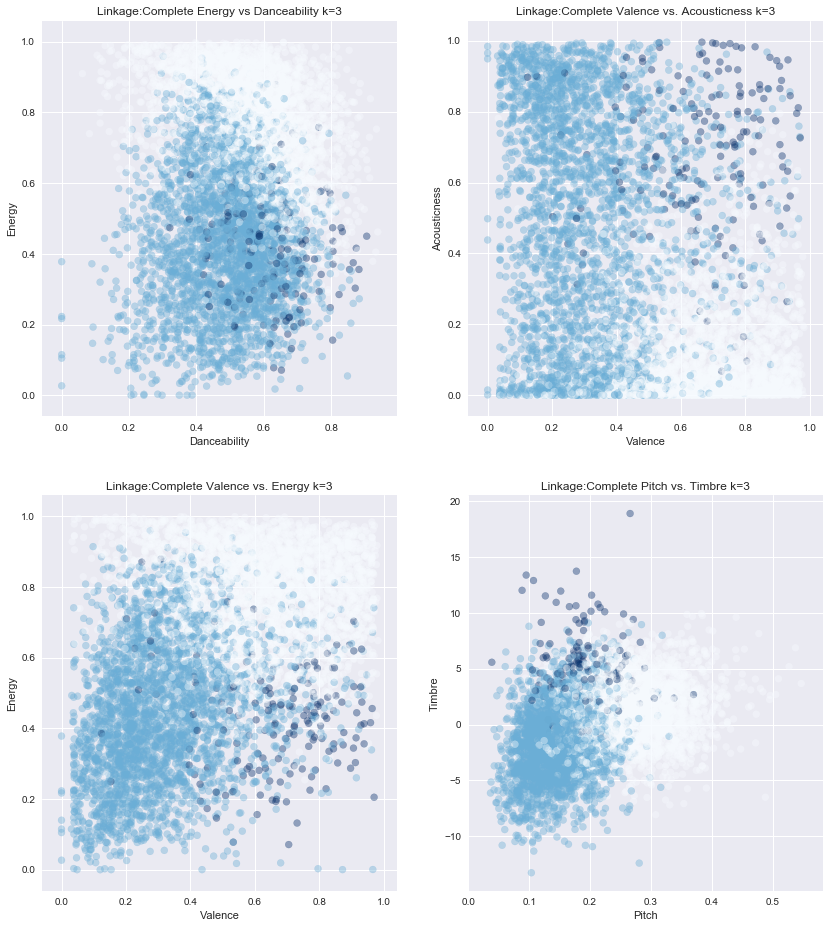

In [170]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['complete_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('Linkage:Complete Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['complete_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('Linkage:Complete Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['complete_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('Linkage:Complete Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['complete_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('Linkage:Complete Pitch vs. Timbre k=3')

plt.savefig('../images/AggComplete_FeaturesClusters_K3.png')

### Visualizing Clusters produced from Agglomerative Clustering (Linkage = Ward)

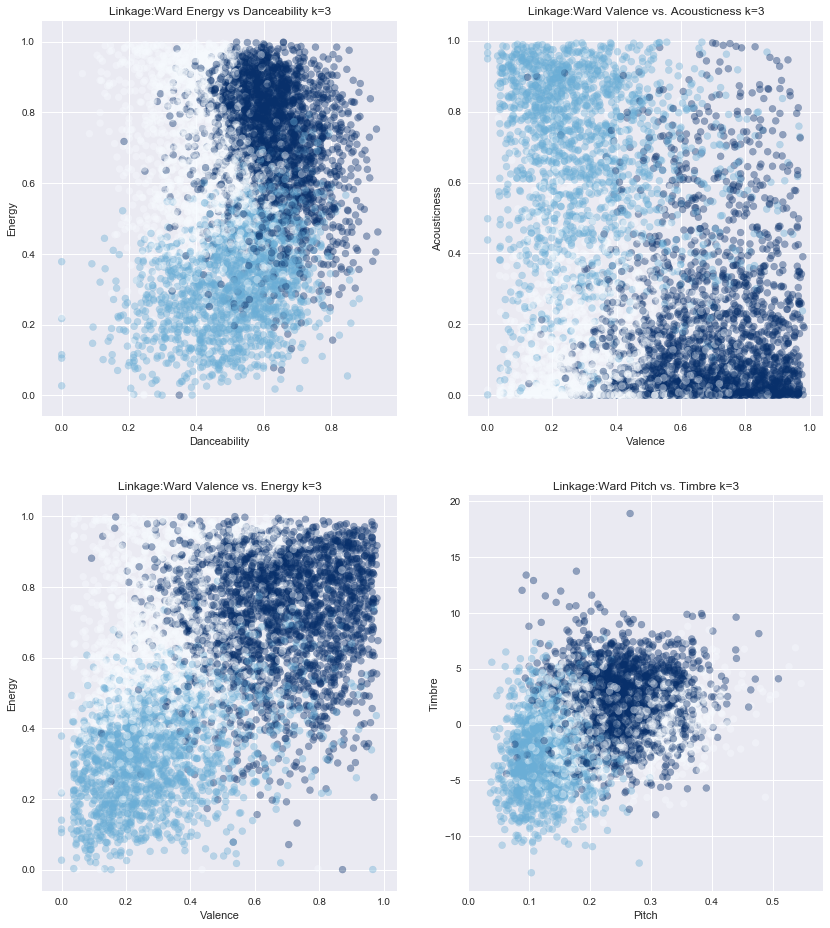

In [171]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['ward_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('Linkage:Ward Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['ward_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('Linkage:Ward Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['ward_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('Linkage:Ward Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['ward_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('Linkage:Ward Pitch vs. Timbre k=3')

plt.savefig('../images/AggWard_FeaturesClusters_K3.png')

#### Summarize Results:

In [173]:
def getClusterSummResults(clustLabel, k=3):
    ''' returns a dataframe with summarized results for the clustering method'''
    
    clust_summ = {'cluster':[],'mSong_tag':[],'count':[], 'Pct Overall Genre': []}
    
    total_msong_pop = songsDF[(songsDF.genre == 'pop')].song_id.count()
    total_msong_country = songsDF[(songsDF.genre == 'country')].song_id.count()
    
    for num in range(k):
        clust_count_cntry = songsDF[(songsDF[clustLabel] == num) & (songsDF.genre == 'country')].song_id.count()
        clust_count_pop   = songsDF[(songsDF[clustLabel] == num) & (songsDF.genre == 'pop')].song_id.count()
    
    
        clust_summ['cluster'].append(num)
        clust_summ['mSong_tag'].append('country')
        clust_summ['count'].append(clust_count_cntry)
        clust_summ['Pct Overall Genre'].append(clust_count_cntry/total_msong_country*100)
    
        clust_summ['cluster'].append(num)
        clust_summ['mSong_tag'].append('pop')
        clust_summ['count'].append(clust_count_pop)
        clust_summ['Pct Overall Genre'].append(clust_count_pop/total_msong_pop*100)

    
    summDF = pd.DataFrame(clust_summ)
    summDF = summDF[['cluster','mSong_tag','count','Pct Overall Genre']].copy()
    return summDF


KMeansDF = getClusterSummResults('K_cluster_n3')
KMeansDF2 = getClusterSummResults('K_cluster_n2',2)
#AggCompleteDF = getClusterSummResults('complete_labels')
AggWardDF = getClusterSummResults('ward_labels')


KMeans - K=2

* Cluster 0 - Low Acoustic
* Cluster 1 - High Acoustic

In [185]:
KMeansDF2

cluster mSong_tag  count  Pct Overall Genre
0        0   country   1793          58.157639
1        0       pop   1724          61.615440
2        1   country   1290          41.842361
3        1       pop   1074          38.384560

In [175]:
KMeansDF

cluster mSong_tag  count  Pct Overall Genre
0        0   country    915          29.678884
1        0       pop    894          31.951394
2        1   country   1035          33.571197
3        1       pop    959          34.274482
4        2   country   1133          36.749919
5        2       pop    945          33.774124

__KMeans Clusters__
- 0 - High Energy, Low Acoustic, Low Danceability, Low Valence, High Pitch
- 1 - High Energy, High Danceability, High Valence, High Timbre
- 2 - High Acoustic, Low Energy, Low Timbre, Low Pitch, Low Valence




 <br>* *majority of the country songs are classified as cluster 2
 <br>* *majority of the pop songs are classified as cluster 1
 <br>* *cluster 3 appears to be the most common features 'overlap' between country and pop songs 

In [176]:
songsDF['year'] = songsDF.year.astype(int)

In [177]:
songsDF.groupby(['K_cluster_n3','genre']).year.agg(['min','max','median','mean'])

min   max  median         mean
K_cluster_n3 genre                                   
0            country  1990  2010    2005  2004.115847
             pop      1990  2010    2005  2003.438479
1            country  1990  2010    2004  2002.338164
             pop      1990  2010    2004  2002.841502
2            country  1990  2010    2005  2003.260371
             pop      1990  2010    2005  2003.324868

In [178]:
songsDF[(songsDF.artist_hotttnesss > .5)].groupby('K_cluster_n3').year.agg(['min','max','median','mean'])

min   max  median         mean
K_cluster_n3                                 
0             1990  2010    2006  2005.346154
1             1990  2010    2005  2004.248217
2             1990  2010    2005  2004.349892

In [179]:
songsDF[(songsDF.artist_hotttnesss > .5) & (songsDF.K_cluster_n3 == 2) & (songsDF.genre == 'pop')].describe().T

count           mean           std           min  \
level_0             290.0    9245.589655   5901.534114     73.000000   
index               290.0    6253.544828   3396.562483    125.000000   
duration            290.0     226.234277     69.688444      1.044440   
artist_familiarity  290.0       0.772423      0.056024      0.635166   
artist_hotttnesss   290.0       0.573291      0.062169      0.500661   
year                290.0    2004.920690      4.614996   1990.000000   
FKRG1               290.0      65.219172      7.000344     50.210000   
fkrg_sent1          290.0       1.000000      0.000000      1.000000   
FKRG2               290.0       5.070966      6.827254     -5.660000   
fkrg_sent2          290.0      23.251724     11.840436      1.000000   
bar_len             290.0     114.151724     49.444223      0.000000   
beat_len            290.0     427.389655    172.554158      0.000000   
seg_len             290.0     706.003448    226.767498     41.000000   
pitch_mean          290.0       0.277161      0.033609      0.184052   
pitch_med           290.0       0.135519      0.039047      0.046500   
timbre_mean         290.0       0.642771      5.526724    -14.539401   
timbre_med          290.0      -1.027540      3.367097    -11.338000   
drop_row            290.0       0.000000      0.000000      0.000000   
country_cnt         290.0       0.000000      0.000000      0.000000   
pop_cnt             290.0       2.837931      1.430492      1.000000   
other_cnt           290.0       1.703448      1.375133      0.000000   
danceability        290.0       0.459203      0.147317      0.000000   
energy              290.0       0.356944      0.148750      0.019300   
key                 290.0       4.300000      3.363194      0.000000   
loudness            290.0     -10.896903      4.089479    -34.981000   
mode                290.0       0.782759      0.413081      0.000000   
speechiness         290.0       0.039874      0.054363      0.000000   
acousticness        290.0       0.626002      0.271306      0.002100   
instrumentalness    290.0       0.047903      0.159160      0.000000   
liveness            290.0       0.154139      0.095781      0.050000   
valence             290.0       0.274862      0.164264      0.000000   
tempo               290.0     115.507069     30.365283      0.000000   
duration_ms         290.0  224766.951724  65726.582995  13520.000000   
time_signature      290.0       3.765517      0.564385      0.000000   
K_cluster_n3        290.0       2.000000      0.000000      2.000000   
pca1                290.0       1.908241      0.947555      0.315882   
pca2                290.0       0.091086      0.926769     -3.512220   
pca3                290.0       0.393873      1.047506     -3.097277   
K_cluster_n2        290.0       1.000000      0.000000      1.000000   
ward_labels         290.0       0.779310      0.470132      0.000000   
complete_labels     290.0       1.010345      0.155287      0.000000   

                              25%            50%            75%            max  
level_0               4359.250000    7668.500000   13839.750000   19622.000000  
index                 3803.750000    5755.500000    9448.500000   12084.000000  
duration               191.953827     227.944035     265.155465     543.842810  
artist_familiarity       0.737437       0.761015       0.796505       0.947328  
artist_hotttnesss        0.527761       0.567507       0.600323       0.804220  
year                  2003.000000    2006.000000    2008.000000    2010.000000  
FKRG1                   60.537500      64.610000      69.770000      97.650000  
fkrg_sent1               1.000000       1.000000       1.000000       1.000000  
FKRG2                    1.007500       3.785000       7.897500      54.220000  
fkrg_sent2              14.000000      23.000000      30.000000      66.000000  
bar_len                 79.000000     108.500000     145.000000     283.000000  
beat_len               

In [91]:
songsDF.columns

Index(['level_0', 'index', 'artist_id', 'tags', 'track_id', 'title', 'song_id',
       'release', 'artist_mbid', 'artist_name', 'duration',
       'artist_familiarity', 'artist_hotttnesss', 'year', 'track_7digitalid',
       'shs_perf', 'shs_work', 'lyrics_text', 'spotifyURI', 'songFeatures',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'country_count', 'pop_count', 'other_count',
       'language', 'lyrics_clean', 'FKRG1', 'fkrg_sent1', 'FKRG2',
       'fkrg_sent2', 'bar_len', 'beat_len', 'seg_len', 'pitch_mean',
       'pitch_med', 'timbre_mean', 'timbre_med', 'K_cluster_n3', 'pca1',
       'pca2', 'K_cluster_n2'],
      dtype='object')

In [96]:
songsDF['year'] = songsDF.year.astype(int)

In [99]:
songsDF.head()

level_0  index           artist_id  \
0        0    0.0  AR009211187B989185   
1        1    1.0  AR00FOZ1187FB5C9F3   
2        4    4.0  AR00FOZ1187FB5C9F3   
5        8    9.0  AR00TGQ1187B994F29   
6        9   12.0  AR00Y9I1187B999412   

                                                tags            track_id  \
0  [(pop rock,), (pop,), (synthpop,), (reggae pop,)]  TRDBNUI128F933DE6E   
1                [(synthpop,), (pop,), (pukkelpop,)]  TRWTSUW12903CD2DEA   
2                [(synthpop,), (pop,), (pukkelpop,)]  TRTMPTG128F92F00A0   
5  [(brazilian pop music,), (pop rock,), (pop,), ...  TRIALWQ128F930725A   
6                                      [(pop rock,)]  TRWTMKM12903CDF74A   

                      title             song_id  \
0              I'm So Sorry  SOZCBYK12AB0180B4D   
1             Stay The Same  SOBGFYV12AB018DEAD   
2               Always More  SOUQQXB12A8C140687   
5                  All Over  SOQHCUX12AB01803B5   
6  Praise The Name Of Satan  SOGNOQV12A58A7DF11   

                                             release  \
0  The Best Of Original British Lovers Rock Volum...   
1                                      Stay The Same   
2                                             Animal   
5                                              SóNós   
6                                          Choronzon   

                            artist_mbid       artist_name   duration  \
0  9dfe78a6-6d91-454e-9b95-9d7722cbc476  Carroll Thompson  260.91057   
1  92337972-f0c5-4ebd-be8c-f6b23d596ae1         autoKratz  404.97587   
2  92337972-f0c5-4ebd-be8c-f6b23d596ae1         autoKratz  255.26812   
5  e61a882e-cee2-4aa9-8d73-bee3c85a44c0      Paula Toller  202.65751   
6  fc1abced-ff90-4a42-9998-2e18cceef041         Akercocke  430.81098   

   artist_familiarity  artist_hotttnesss  year track_7digitalid shs_perf  \
0            0.396818           0.297405  2007          6144722       -1   
1            0.632410           0.499475  2008          6548152       -1   
2            0.632410           0.499475  2009          5334937       -1   
5            0.530135           0.399928  2007          5917832       -1   
6            0.604705           0.400269  2003          7574066       -1   

  shs_work                                        lyrics_text  \
0        0  Gabrielle\nGabrielle\nI'm So Glad\nI can never...   
1        0  We can't always stay the same, but we all keep...   
2        0  Faith I'm sure, there's something wanting but ...   
5        0  You won't tear your soul apart\nFrom youself\n...   
6        0  Mephistopheles\nExtract from concealment\nEnli...   

               spotifyURI                                       songFeatures  \
0  4EPZgfbYO1gjE7LeiNBLtx  [{'danceability': 0.862, 'energy': 0.34, 'key'...   
1  1gZ4TP1pQwRD5WhYKDG0jw  [{'danceability': 0.602, 'energy': 0.733, 'key...   
2  6PWoHhgOdh2gAn0FUAdbff  [{'danceability': 0.596, 'energy': 0.976, 'key...   
5  5VbTkLx44JnBCY4biW6f12  [{'danceability': 0.766, 'energy': 0.541, 'key...   
6  5wpvXMGKOu2rWHpQAzH4Tb  [{'danceability': 0.275, 'energy': 0.823, 'key...   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.803   0.994  0.0    -4.202   1.0       0.1740      0.004290   
1         0.641   0.801  7.0    -4.179   0.0       0.0302      0.002870   
2         0.602   0.733  4.0    -4.019   0.0       0.3600      0.000056   
5         0.649   0.468  7.0    -9.457   1.0       0.0274      0.649000   
6         0.419   0.924  7.0    -6.015   1.0       0.0828      0.000061   

   instrumentalness  liveness  valence    tempo            type  \
0          0.463000    0.0432   0.0384  141.081  audio_features   
1          0.002620    0.0716   0.9160  127.000  audio_features   
2          0.000032    0.2270   0.4720  129.943  audio_features   
5          0.002940    0.1170   0.2860  135.098  audio_features   
6          0.841000    0.0996   0.2010  124.040  audio_features   

                       id              

In [180]:
AggCompleteDF

cluster mSong_tag  count  Pct Overall Genre
0        0   country   1445          46.869932
1        0       pop   1391          49.714081
2        1   country   1528          49.562115
3        1       pop   1351          48.284489
4        2   country    110           3.567953
5        2       pop     56           2.001430

__Agglomerative Linkage: Complete__
- 0 - High Acoustic, Low Energy, Low Timbre, Low Pitch, Low Valence
- 1 - High Energy, High Danceability, High Valence, High Timbre
- 2 - High Energy, Low Acoustic, Low Danceability, Low Valence, High Pitch



In [181]:
AggWardDF

cluster mSong_tag  count  Pct Overall Genre
0        0   country    927          30.068115
1        0       pop    890          31.808435
2        1   country    930          30.165423
3        1       pop    751          26.840600
4        2   country   1226          39.766461
5        2       pop   1157          41.350965

__Agglomerative Linkage: Ward__
- 0 - High Energy, High Danceability, High Valence, High Timbre
- 1 - High Acoustic, Low Energy, Low Timbre, Low Pitch, Low Valence
- 2 - High Energy, Low Acoustic, Low Danceability, Low Valence, High Pitch

### Findings:

1) The cluster characteristics produced by the three different cluster methods were similar.  Main clusters can be described with the following features:

- lower energy, high acoustic, lowest valence, low timbre, low pitch
- high energy, low valence, high pitch, low acoustic
- High energy, high danceability, high valence, high timbre

2) With the audio features we were able to collect, none of these features could clearly distinguish a country song from a Pop song, although majority of Country songs are classified under the cluster with (lower energy, high acoustic, lowest valence, low timbre, low pitch), while majority of the Pop songs are classified under the cluster with (high energy, low valence, high pitch, low acoustic).

3) Looking at the scatter plots for the results of the different clustering methods, the results from KMeans appear to have more distinct clusters between the different features which were plotted out.  

4) Classification of songs between KMeans and Agglomerate Clustering with Linkage = 'complete appear to be more consistent, where majority of the country songs are classified under the cluster with features (High Acoustic, Low Energy, Low Timbre, Low Pitch, Low Valence), and majority of pop songs were classified under the cluster with features (High Energy, Low Acoustic, Low Danceability, Low Valence, High Pitch).  Whereas for Agglomerate clustering wih linkage = 'ward', even if the cluster features are the same, it classified the songs differently.  Majority of the songs were classified in the 'overlap' class -- with features: High Energy, High Danceability, High Valence, High Timbre.



### Next Steps:

Evaluate clusters...formulate conclusion.